In [19]:
import importlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sub import estimate

importlib.reload(estimate)

plt.rcParams["figure.figsize"] = (20, 12)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [20]:
LOG_FILE_PATH = "../dataset/sample-trials/4_1_51.txt"
GIS_BASE_PATH = "../dataset/gis/"
BEACON_LIST_PATH = GIS_BASE_PATH + "beacon_list.csv"
FLOOR_NAMES = ["FLU01", "FLU02", "FLD01"]

In [21]:
from sub import pdr

importlib.reload(pdr)

data = pdr.read_log_data(LOG_FILE_PATH)
acc_df, gyro_df, mgf_df, ground_truth_df, blescans_df = pdr.convert_to_dataframes(data)

In [22]:
from sub import pdr

importlib.reload(pdr)

map_dict = pdr.load_floor_maps(FLOOR_NAMES, GIS_BASE_PATH)
edit_map_dict = pdr.load_floor_maps(FLOOR_NAMES, GIS_BASE_PATH, "_edited")
floor_name = ground_truth_df.floor_name[0]

dx = 0.01
dy = 0.01

In [23]:
from scipy.signal import find_peaks

acc_df["norm"] = np.sqrt(acc_df["x"] ** 2 + acc_df["y"] ** 2 + acc_df["z"] ** 2)
acc_df["rolling_norm"] = acc_df["norm"].rolling(10).mean()

peaks, _ = find_peaks(acc_df["rolling_norm"], height=12, distance=10)

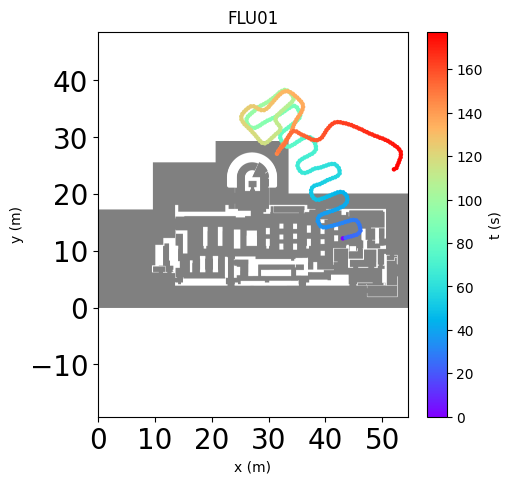

In [24]:
from sub import pdr, utils

importlib.reload(utils)
importlib.reload(pdr)

cumulative_displacement_angle, trajectory_df = pdr.estimate_trajectory(
    acc_df,
    gyro_df,
    ground_truth_first_point={
        "x": ground_truth_df.x[0],
        "y": ground_truth_df.y[0],
    },
)

utils.plot_displacement_map(
    map_dict,
    floor_name,
    dx,
    dy,
    trajectory_df,
)

initial_direction: 0.8316046661187979


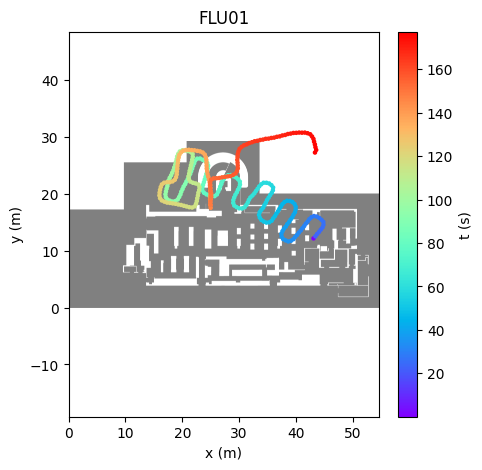

In [25]:
from sub import utils

importlib.reload(utils)

initial_direction = utils.extract_rotation(
    [
        ground_truth_df.q0[0],
        ground_truth_df.q1[0],
        ground_truth_df.q2[0],
        ground_truth_df.q3[0],
    ],
)

print(f"initial_direction: {initial_direction}")

angle_df = estimate.convert_to_angle_from_gyro(gyro_df)
angle_df_in_step_timing = estimate.convert_to_peek_angle(gyro_df, acc_df, peaks)
diff = angle_df_in_step_timing["x"][0] - initial_direction
rotate_by_first_half_angle = pd.DataFrame(
    {
        "ts": angle_df["ts"],
        "x": angle_df["x"] - diff,
    },
)

rotate_by_first_half_angle_displacement = (
    estimate.convert_to_peek_angle_and_compute_displacement_by_angle(
        rotate_by_first_half_angle,
        acc_df,
        0.5,
        {"x": ground_truth_df.x[0], "y": ground_truth_df.y[0]},
        ground_truth_df["ts"][0],
    )
)

utils.plot_displacement_map(
    map_dict,
    floor_name,
    dx,
    dy,
    rotate_by_first_half_angle_displacement,
)

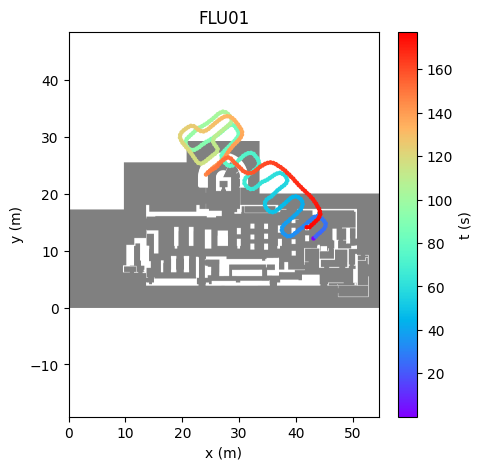

In [26]:
from sub import drift, utils

importlib.reload(drift)
importlib.reload(utils)


first_time_remove_drift_angle, first_time_remove_drift_angle_displacement = (
    drift.remove_drift_in_angle_df(
        acc_df,
        rotate_by_first_half_angle,
        ground_truth_df,
    )
)


# マップの描画
utils.plot_displacement_map(
    map_dict,
    floor_name,
    dx,
    dy,
    first_time_remove_drift_angle_displacement,
    fig_size=(5, 5),
)

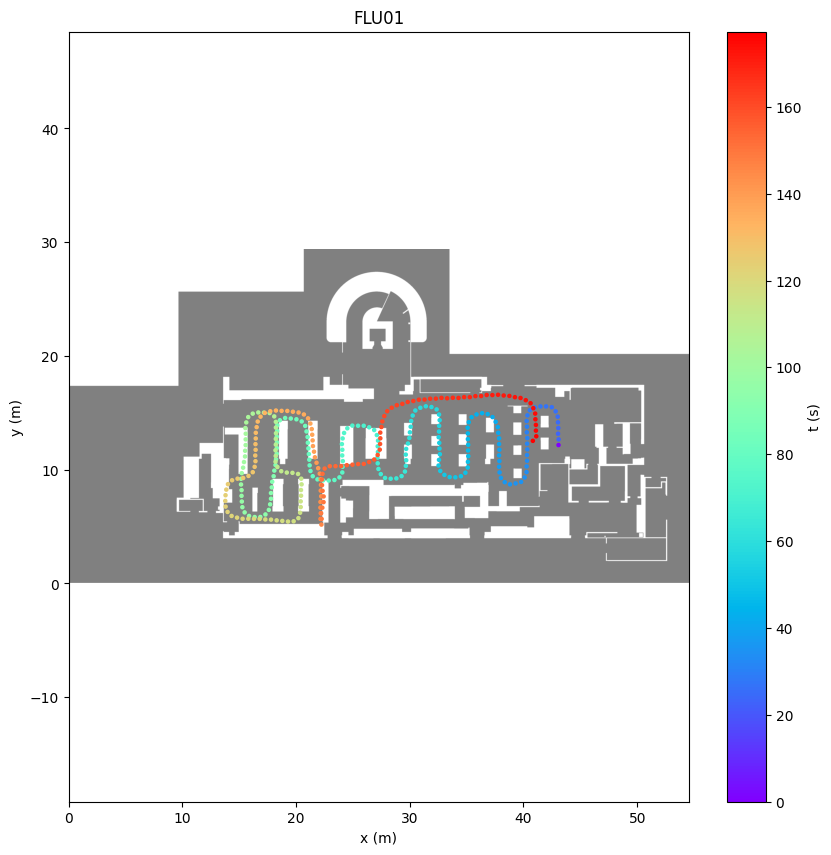

In [36]:
# refactored code

from sub import estimate, pdr_direction, utils

importlib.reload(pdr_direction)
importlib.reload(utils)
importlib.reload(estimate)

straight_angle_df, straight_angle_displacement = (
    pdr_direction.rotate_trajectory_to_optimal_alignment_using_map(
        acc_df,
        first_time_remove_drift_angle,
        edit_map_dict,
        floor_name,
        dx,
        dy,
        ground_truth_first_point={
            "x": ground_truth_df.x[0],
            "y": ground_truth_df.y[0],
        },
    )
)

utils.plot_displacement_map(
    map_dict,
    floor_name,
    dx,
    dy,
    straight_angle_displacement,
    fig_size=(10, 10),
)

水平成分と垂直成分の色を変更するコード


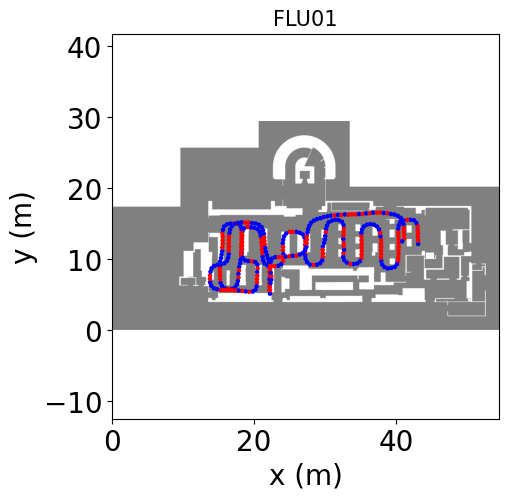

In [28]:
from sub import utils

importlib.reload(utils)

utils.plot_map(map_dict, floor_name, dx, dy, font_size=15, fig_size=(5, 5))

colors = straight_angle_displacement["is_vertical_or_horizontal"].map(
    {True: "r", False: "b", np.nan: "b"},
)

plt.scatter(
    straight_angle_displacement.x_displacement,
    straight_angle_displacement.y_displacement,
    c=colors,
    s=5,
)
plt.tick_params(labelsize=20)
plt.xlabel("x (m)", fontsize=20)
plt.ylabel("y (m)", fontsize=20)
plt.show()

               ts          x
0        0.003125   1.478425
1        0.013075   1.476875
2        0.023024   1.475318
3        0.032974   1.473762
4        0.042923   1.472218
5        0.052873   1.470662
6        0.062822   1.469075
7        0.072772   1.467409
8        0.082721   1.465718
9        0.092671   1.464027
10       0.102620   1.462379
11       0.112570   1.460829
12       0.122519   1.459413
13       0.132469   1.458162
14       0.142418   1.457101
15       0.152368   1.456247
16       0.162317   1.455589
17       0.172267   1.455156
18       0.182216   1.455048
19       0.192166   1.455135
20       0.202115   1.455435
21       0.212065   1.455895
22       0.222014   1.456434
23       0.231964   1.457003
24       0.241914   1.457548
25       0.251863   1.458008
26       0.261812   1.458406
27       0.271762   1.458725
28       0.281712   1.458989
29       0.291661   1.459247
30       0.301611   1.459481
31       0.311560   1.459739
32       0.321510   1.460076
33       0.331

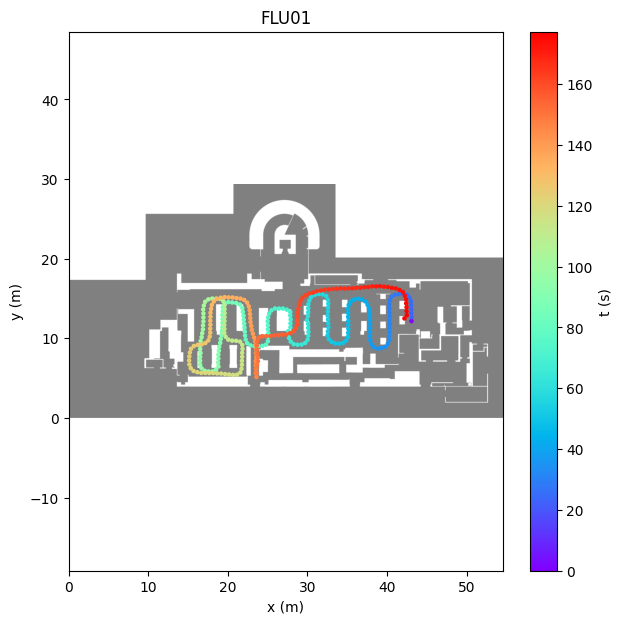

In [40]:
from sub import estimate, map_matching, stable, utils

importlib.reload(estimate)
importlib.reload(map_matching)
importlib.reload(stable)
importlib.reload(utils)

correct_unpassable_displacement = map_matching.move_unwalkable_points_to_walkable(
    acc_df,
    straight_angle_df,
    map_dict,
    floor_name,
    dx,
    dy,
    ground_truth_first_point={
        "x": ground_truth_df.x[0],
        "y": ground_truth_df.y[0],
    },
)


utils.plot_displacement_map(
    map_dict,
    floor_name,
    dx,
    dy,
    correct_unpassable_displacement,
    fig_size=(7, 7),
    font_size=10,
    label_size=10,
)

In [30]:
output_df = pd.DataFrame(
    {
        "timestamp": correct_unpassable_displacement["ts"],
        "x": correct_unpassable_displacement["x_displacement"],
        "y": correct_unpassable_displacement["y_displacement"],
        "floor": floor_name,
    },
)

# output_df.to_csv("8_1_pdr_est.csv", index=False, header=False)